# **Exploratory Data Analysis**

## Objectives

* Get a better understanding of the data using Pandas profiling and correlation studies
* Answer business requirement 1:
    * The client is interested in which attributes correlate most closely with heart disease, ie what are the most common risk factors?

## Inputs

* outputs/datasets/collection/HeartDiseasePrediction.csv

## Outputs

* Plots for dashboard
* More data ADD MORE DETAIL LATER!


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/jfpaliga/CVD-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/home/jfpaliga/CVD-predictor'

# Load Data

Load the dataset that was saved at the end of the previous notebook.

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HeartDiseasePrediction.csv")
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,low diabetes risk,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,low diabetes risk,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,low diabetes risk,ST,98,N,0.0,Up,0


---

# Pandas Profiling

In order to better understand the dataset, data profiling is carried out using the ProfileReport class from the ydata_profiling library.

This will give an overview of the dataset and it's characteristics, analyse the features using statistical methods and investigate relationships between features.

From the overview, we can see there are no missing values as we calculated previously. There are alerts for values of zero in the following features: Cholesterol, Oldpeak and HeartDisease.

* We are not concerned with zero values in HeartDisease as this is our target (where 0 is no heart disease and 1 is heart disease).
* There are a large number of zero values in Cholesterol (18.7% of examples), so this will require data cleaning.
* The Oldpeak feature requires more understanding of the feature itself. This feature is measuring a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline.
* An ST depression of > 2 mm in relation to the isoelectric line may be indicative of reversible ischaemia (restricted blood flow).
* A value of 0 in the Oldpeak feature is valid. Due to the imbalance of values, this feature may be better if converted to a categorical feature.

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, title="Overview of the original heart disease dataset", minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Next, we will examine the numerical features to determine if there are any outliers. We drop the target column then iterate through all numerical features.
* MaxHR has two outlier points of data below Q1 - 1.5 x IQR.
* RestingBP, Cholesterol and Oldpeak all have significant outliers.
* For Cholesterol, a large number of outliers are zero values.

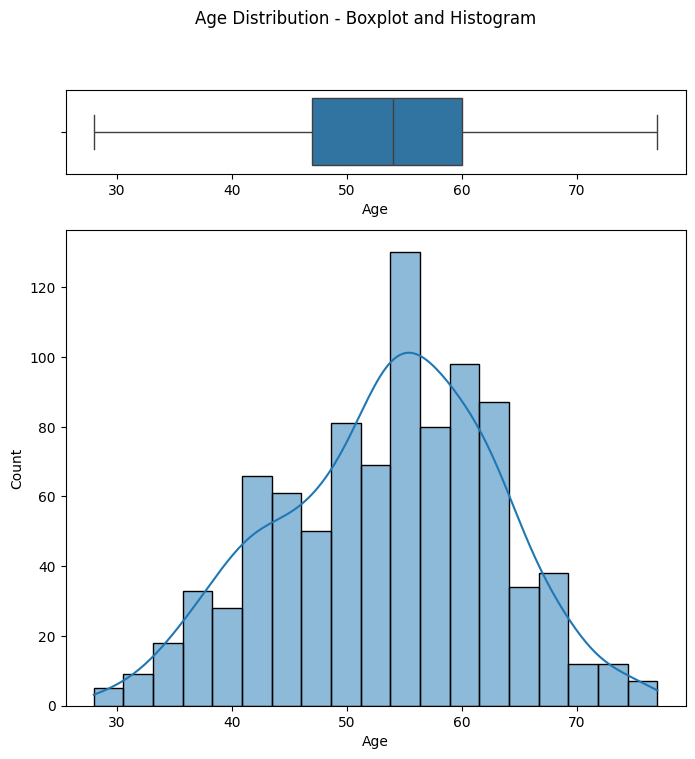

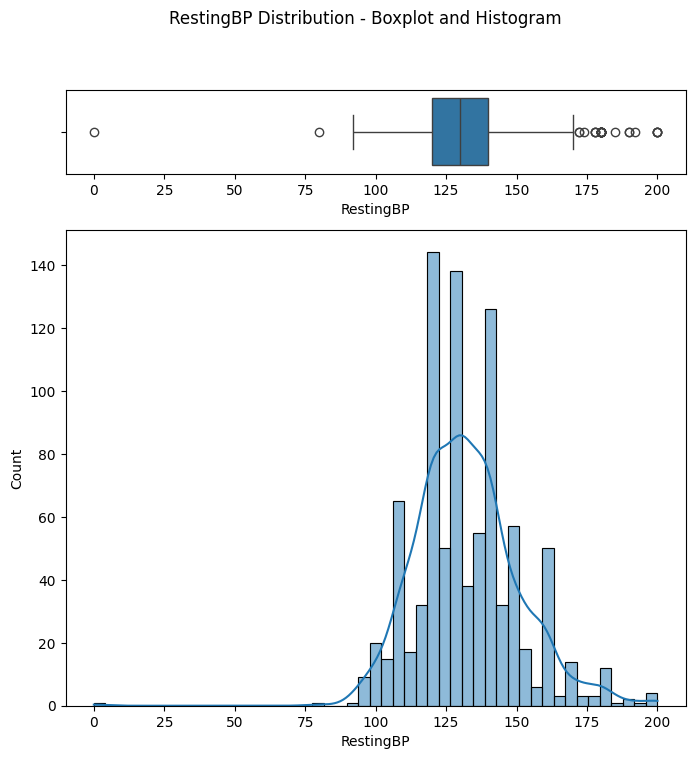

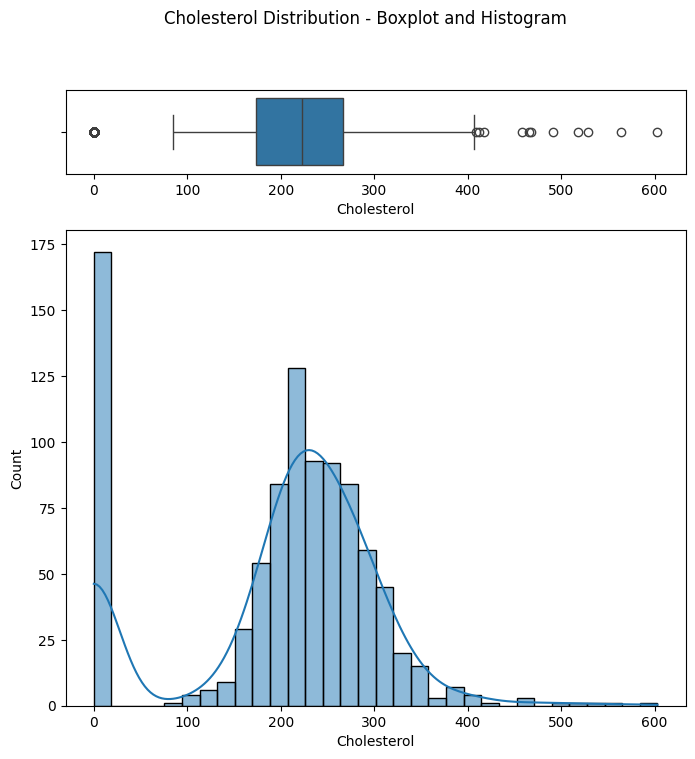

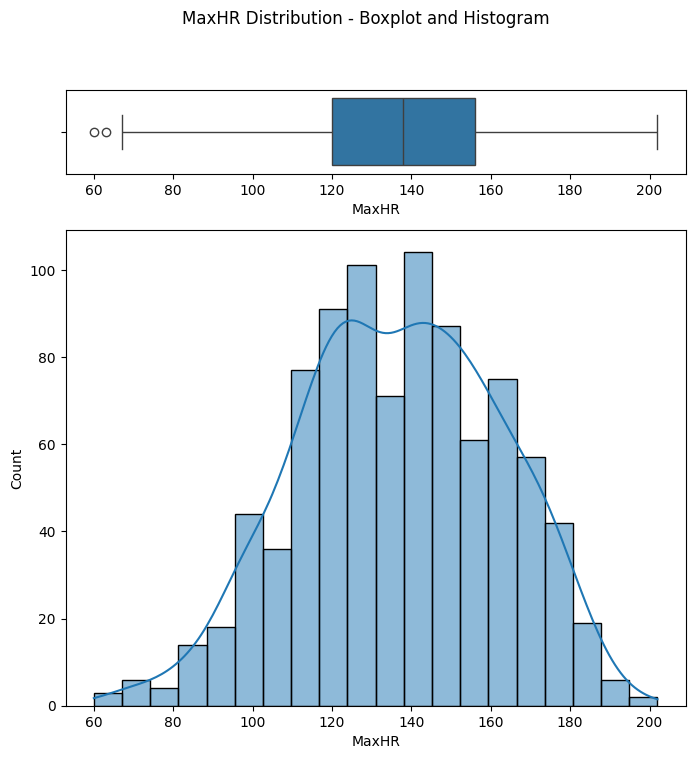

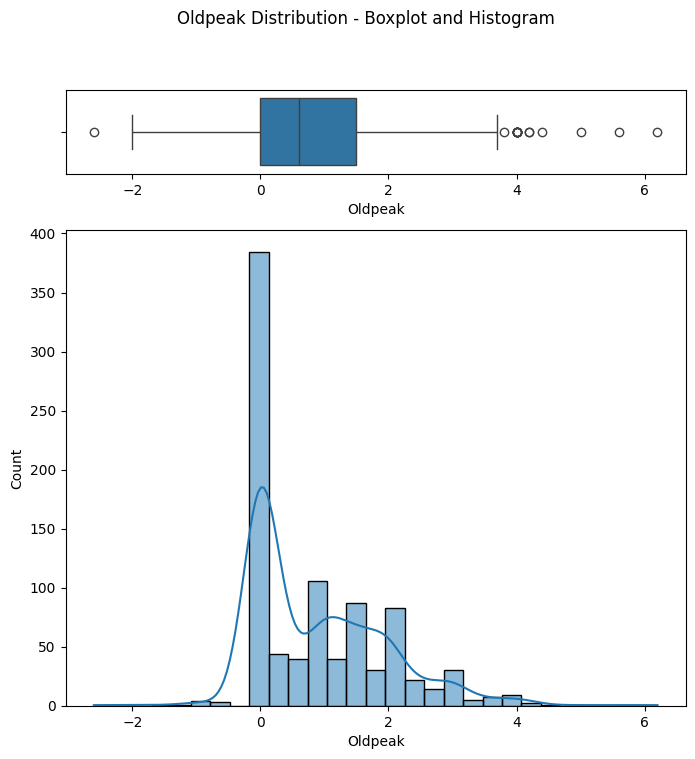

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df_outliers = df.drop("HeartDisease", axis=1)

for col in df_outliers.select_dtypes(include="number").columns:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df, x=col, ax=axes[0])
    sns.histplot(data=df, x=col, kde=True, ax=axes[1])
    fig.suptitle(f"{col} Distribution - Boxplot and Histogram")
    plt.show()
    print("\n")

##  Analysis of Features with Outliers

First, let's examine how many outliers there are in each feature and the skewness and kurtosis values for those features.

In [23]:
outliers_df = df.filter(["RestingBP", "Cholesterol", "Oldpeak"])

def calc_skew_kurtosis(df, col):
    print(f"For {col} | skewness: {df[col].skew().round(2)} | kurtosis: {df[col].kurtosis().round(2)}")

def calc_IQR(df, col):
    return df[col].quantile(q=0.75) - df[col].quantile(q=0.25)

def num_of_outliers(df):
    for col in df.columns:
        IQR = calc_IQR(df, col)
        below_q1 = 0
        above_q3 = 0

        for obs in df[col]:
            if obs < (df[col].quantile(q=0.25) - 1.5*IQR):
                below_q1 += 1
            elif obs > (df[col].quantile(q=0.75) + 1.5*IQR):
                above_q3 += 1

        calc_skew_kurtosis(df, col)
        print(f"**{col}** There are {below_q1} outliers below Q1 - 1.5 * IQR")
        print(f"**{col}** There are {above_q3} outliers above Q3 + 1.5 * IQR")
        print("\n")

num_of_outliers(outliers_df)

For RestingBP | skewness: 0.18 | kurtosis: 3.27
**RestingBP** There are 2 outliers below Q1 - 1.5 * IQR
**RestingBP** There are 26 outliers above Q3 + 1.5 * IQR


For Cholesterol | skewness: -0.61 | kurtosis: 0.12
**Cholesterol** There are 172 outliers below Q1 - 1.5 * IQR
**Cholesterol** There are 11 outliers above Q3 + 1.5 * IQR


For Oldpeak | skewness: 1.02 | kurtosis: 1.2
**Oldpeak** There are 1 outliers below Q1 - 1.5 * IQR
**Oldpeak** There are 15 outliers above Q3 + 1.5 * IQR




Displaying this visually:

--- RestingBP ---


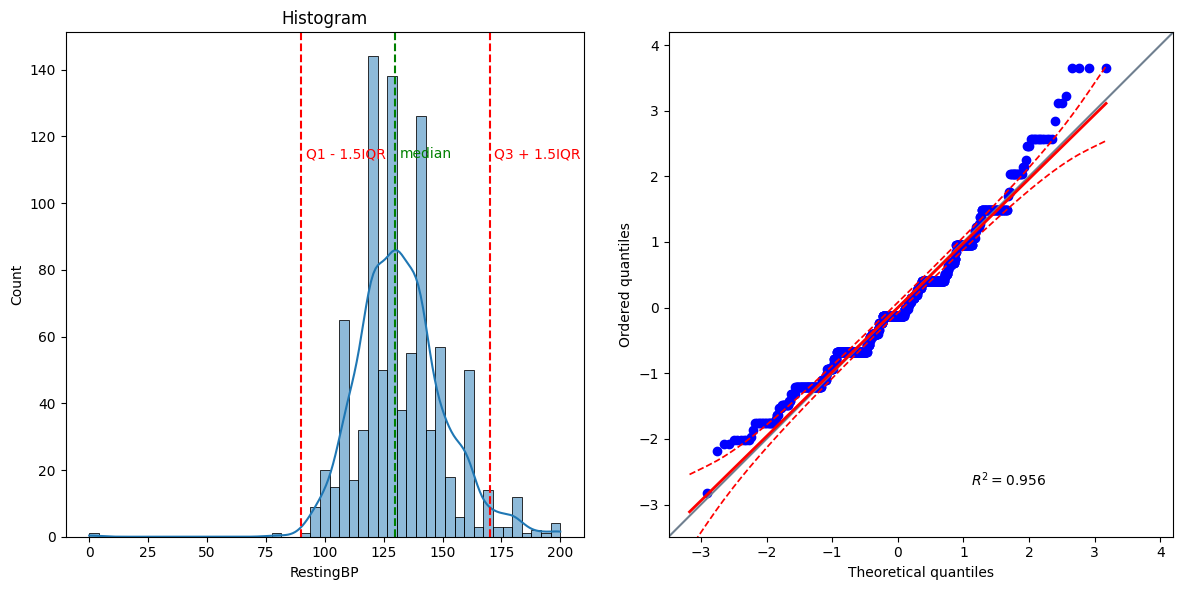

--- Cholesterol ---


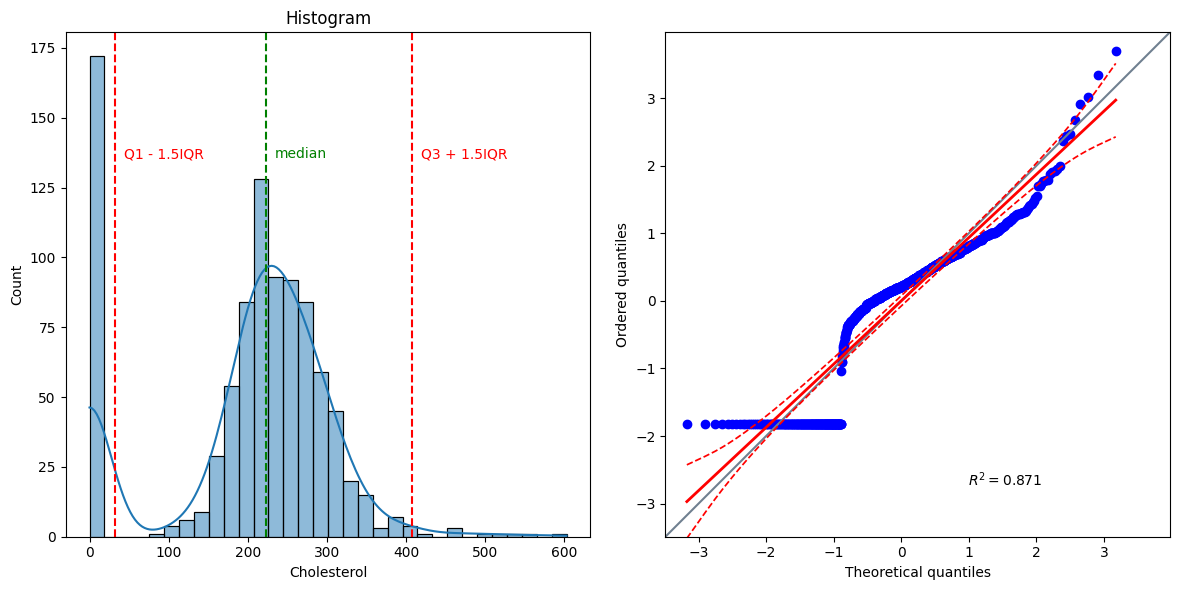

--- Oldpeak ---


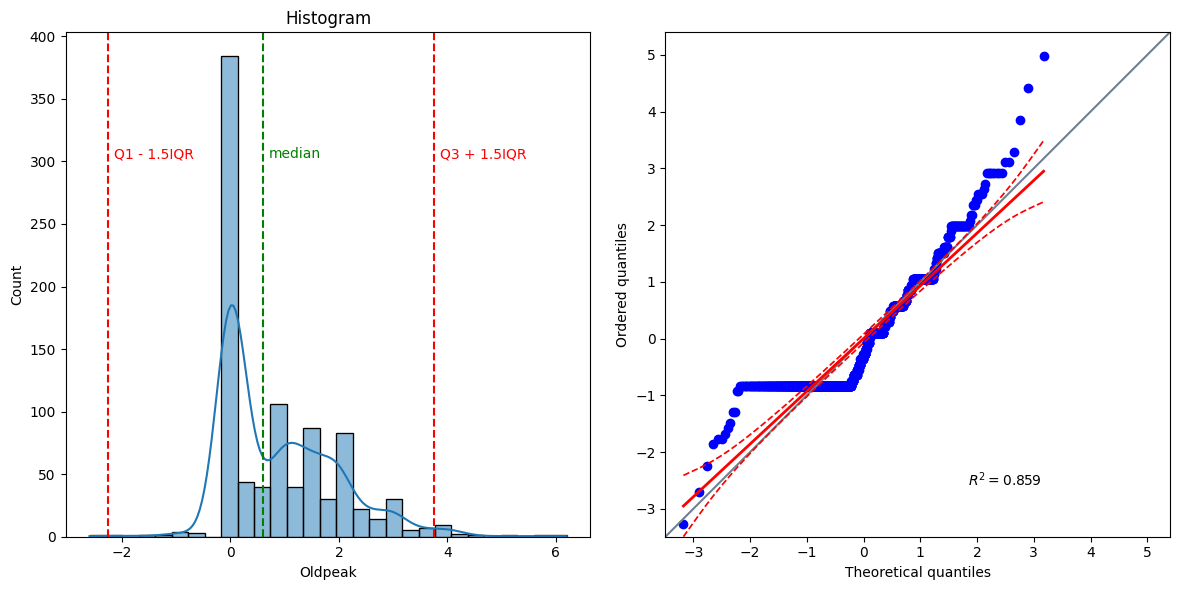

In [25]:
import pingouin as pg

def plot_distribution_and_qq(df):
    for col in df.columns:
        IQR = calc_IQR(df, col)

        print(f"--- {col} ---")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        sns.histplot(data=df, x=col, kde=True, ax=axes[0])
        axes[0].set_title("Histogram")
        axes[0].axvline(df[col].median(), color="g", linestyle="dashed", linewidth="1.5")
        axes[0].text(x=df[col].median() + df[col].std()/10, y=axes[0].get_ylim()[1] * 0.75, s="median", fontsize=10, c="g")

        axes[0].axvline(df[col].quantile(q=0.25) - 1.5*IQR, color="r", linestyle="dashed", linewidth="1.5")
        axes[0].text(x=df[col].quantile(q=0.25) - 1.5*IQR + df[col].std()/10, y=axes[0].get_ylim()[1] * 0.75, s="Q1 - 1.5IQR", fontsize=10, c="r")

        axes[0].axvline(df[col].quantile(q=0.75) + 1.5*IQR, color="r", linestyle="dashed", linewidth="1.5")
        axes[0].text(x=df[col].quantile(q=0.75) + 1.5*IQR + df[col].std()/10, y=axes[0].get_ylim()[1] * 0.75, s="Q3 + 1.5IQR", fontsize=10, c="r")

        pg.qqplot(df[col], dist="norm", ax=axes[1])

        plt.tight_layout()
        plt.show()

plot_distribution_and_qq(outliers_df)

How is the distribution of RestingBP effected if the two lower outliers are removed?

--- RestingBP ---


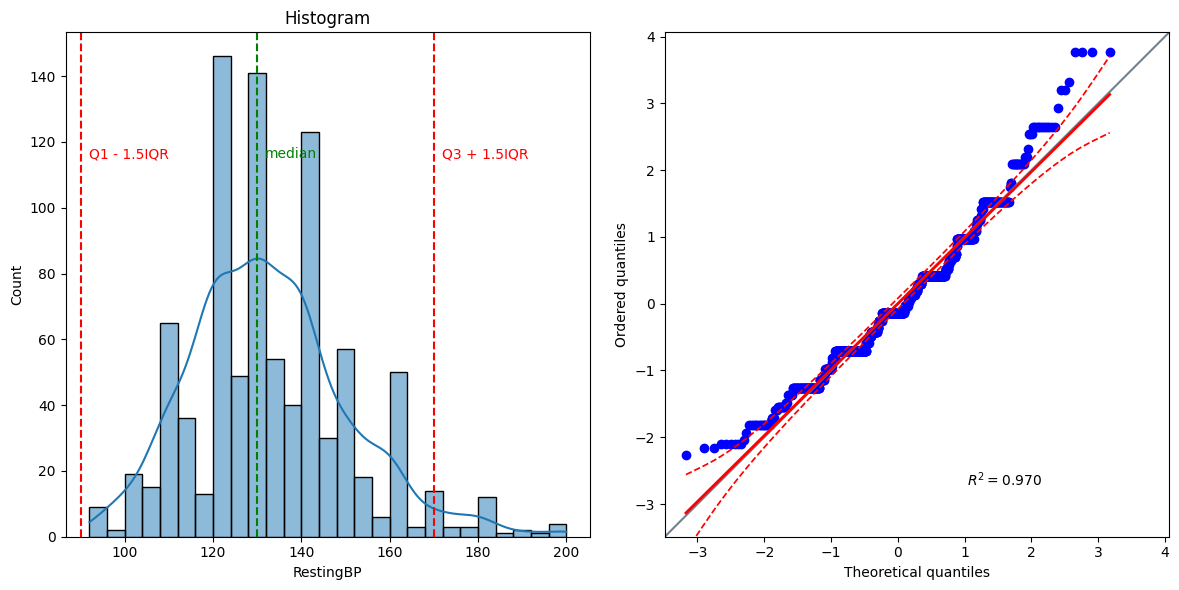

In [36]:
restingBP_IQR = calc_IQR(outliers_df, "RestingBP")
restingBP_Q1 = outliers_df["RestingBP"].quantile(q=0.25)

restingBP_with_no_low_outliers = outliers_df.query("RestingBP >= @restingBP_Q1 - 1.5*@restingBP_IQR")

restingBP_with_no_low_outliers_df = restingBP_with_no_low_outliers["RestingBP"].to_frame()

plot_distribution_and_qq(restingBP_with_no_low_outliers_df)

How about it we apply numerical variable transformations to RestingBP? Can we achieve a more normalised distribution?

In [40]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt

restingBP_with_no_low_outliers_df.dtypes

# pipeline = Pipeline([
#     ( "log", vt.LogTransformer() )
# ])

# restingBP_transformed_df = pipeline.fit_transform(restingBP_with_no_low_outliers_df)

# plot_distribution_and_qq(restingBP_transformed_df)

RestingBP    int64
dtype: object

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
